In [1]:
%pwd

'/cephfs/volumes/hpc_data_usr/k24083007/2070c87e-fe07-4f03-a6c4-cae0de8ce617'

In [2]:
%cd cmu-mosei-experiments/OMGEmotionChallenge

/cephfs/volumes/hpc_data_usr/k24083007/2070c87e-fe07-4f03-a6c4-cae0de8ce617/cmu-mosei-experiments/OMGEmotionChallenge


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os

# Set up the environment
plt.style.use('default')
sns.set_palette("husl")

import scipy.stats as stats
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings('ignore')

# Let current directory be base_dir
base_dir = os.getcwd()

In [4]:
# Load the dataset
train_videos = pd.read_csv(os.path.join(base_dir, 'omg_TrainVideos.csv'))
validation_videos = pd.read_csv(os.path.join(base_dir, 'omg_ValidationVideos.csv'))
test_videos = pd.read_csv(os.path.join(base_dir, 'omg_TestVideos_WithLabels.csv'))

train_transcripts = pd.read_csv(os.path.join(base_dir, 'omg_TrainTranscripts.csv'))
validation_transcripts = pd.read_csv(os.path.join(base_dir, 'omg_ValidationTranscripts.csv'))
test_transcripts = pd.read_csv(os.path.join(base_dir, 'omg_TestTranscripts.tsv'), sep=',')

print("OMGEmotion Dataset Overview")
print(f"Training videos:   {len(train_videos)} utterances")
print(f"Validation videos: {len(validation_videos)} utterances")
print(f"Test videos:       {len(test_videos)} utterances")
print(f"Total utterances:  {len(train_videos) + len(validation_videos) + len(test_videos)}")

print(f"\nUnique videos in training: {train_videos['video'].nunique()}")
print(f"Unique videos in validation: {validation_videos['video'].nunique()}")
print(f"Unique videos in test: {test_videos['video'].nunique()}")


print("\n---------------------------Sample Training Data ---------------------------")
print(train_videos.head(3))

OMGEmotion Dataset Overview
Training videos:   2442 utterances
Validation videos: 617 utterances
Test videos:       2229 utterances
Total utterances:  5288

Unique videos in training: 231
Unique videos in validation: 60
Unique videos in test: 204

---------------------------Sample Training Data ---------------------------
                                          link      start        end  \
0  https://www.youtube.com/watch?v=CROcsl0lIec  15.412684  19.682865   
1  https://www.youtube.com/watch?v=CROcsl0lIec  21.250822  36.796949   
2  https://www.youtube.com/watch?v=CROcsl0lIec  37.130556  45.337310   

       video        utterance   arousal   valence  EmotionMaxVote  
0  5b44393ed  utterance_4.mp4  0.170091 -0.023697               4  
1  5b44393ed  utterance_6.mp4  0.417668  0.292947               3  
2  5b44393ed  utterance_7.mp4  0.398646  0.325004               4  


In [5]:
EMOTION_LABELS = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}

# Combine all data for overall analysis
all_data = pd.concat([train_videos, validation_videos, test_videos], ignore_index=True)

# Categorical emotion distribution
emotion_counts = all_data['EmotionMaxVote'].value_counts().sort_index()
emotion_counts = emotion_counts.rename(index=EMOTION_LABELS)

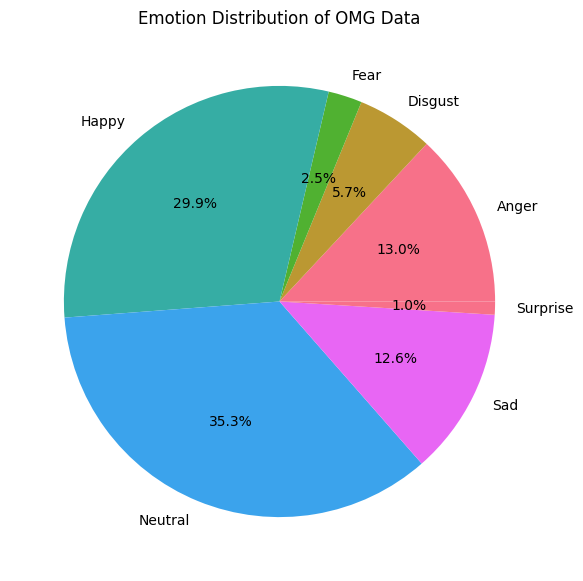

In [35]:
# Emotion distribution analysis
plt.figure(figsize=(10, 7))
# Emotion distribution pie chart
plt.pie(emotion_counts.values, labels=emotion_counts.index.tolist(), autopct='%1.1f%%')
plt.title('Emotion Distribution of OMG Data')
plt.show()

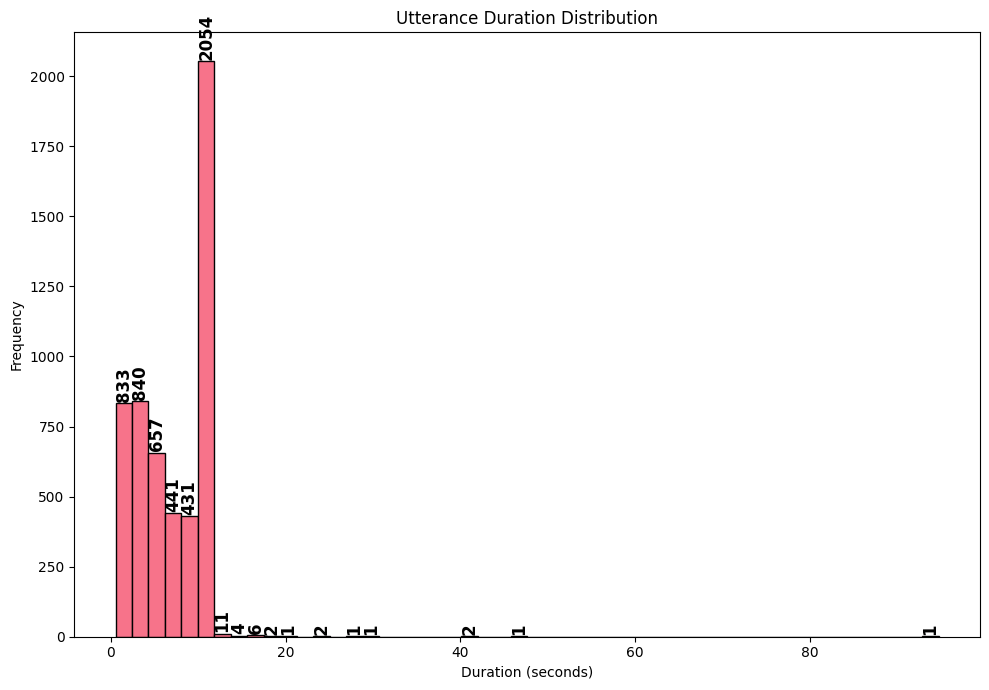

In [37]:
# Video duration distribution
plt.figure(figsize=(10, 7))
durations = all_data['end'] - all_data['start']
hist, bins, _ = plt.hist(durations, bins=50, alpha=0.99, edgecolor='black')
bin_centers = 0.5 * (bins[:-1] + bins[1:])
for count, x in zip(hist, bin_centers):
    if count > 0:  # Only show labels for non-empty bins
        plt.text(x, count + 5, f'{int(count)}', 
                ha='center', va='bottom', fontsize=12, fontweight='bold', rotation=90)

plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Utterance Duration Distribution')
plt.tight_layout()  
plt.show()

In [38]:
print("Emotion Distribution:")
for emotion, count in emotion_counts.items():
    percentage = (count / len(all_data)) * 100
    print(f"   {emotion:<9}: {count:<4} ({percentage:.1f}%)")
    
print(f"\nDuration Statistics:")
print(f"   Mean utterance duration: {durations.mean():.2f} seconds")
print(f"   Median utterance duration: {durations.median():.2f} seconds")
print(f"   Min duration: {durations.min():.2f} seconds")
print(f"   Max duration: {durations.max():.2f} seconds")

Emotion Distribution:
   Anger    : 690  (13.0%)
   Disgust  : 304  (5.7%)
   Fear     : 134  (2.5%)
   Happy    : 1579 (29.9%)
   Neutral  : 1865 (35.3%)
   Sad      : 664  (12.6%)
   Surprise : 52   (1.0%)

Duration Statistics:
   Mean utterance duration: 6.97 seconds
   Median utterance duration: 7.53 seconds
   Min duration: 0.53 seconds
   Max duration: 94.79 seconds


In [49]:
# Theoretical V/A values (Warriner et al. 2013), raw (1-9) scale
warriner_raw = {
    'Anger':    (2.17, 6.60),
    'Disgust':  (2.92, 5.51),
    'Fear':     (2.30, 6.56),
    'Happy':    (8.47, 6.05),
    'Neutral':  (5.00, 3.00),  # midpoint convention
    'Sad':      (2.10, 3.21),
    'Surprise': (6.97, 5.61)
}

# Normalize from [1,9] to [-1,1]
# Formula: x_norm = (x - 5) / 4, where 5 is midpoint of 1-9

# Updated normalization functions to match OMG data scales
def normalize_warriner_valence(x):
    """Normalize Warriner valence from [1,9] to [-1,1] to match OMG valence scale"""
    return (x - 5.0) / 4.0

def normalize_warriner_arousal(x):
    """Normalize Warriner arousal from [1,9] to [0,1] to match OMG arousal scale"""
    return (x - 1.0) / 8.0  # Maps [1,9] to [0,1]

# Updated mapping with correct arousal normalization
mapping = {
    emotion: (normalize_warriner_valence(v), normalize_warriner_arousal(a))
    for emotion, (v, a) in warriner_raw.items()
}

print("CORRECTED NORMALIZATION:")
print("=" * 50)
print("Valence: (x-5)/4 maps [1,9] → [-1,1] (matches OMG)")
print("Arousal: (x-1)/8 maps [1,9] → [0,1] (matches OMG)")
print()

print("Corrected Theoretical Values:")
for emotion, (v, a) in mapping.items():
    print(f"  {emotion:8}: V={v:+6.3f}, A={a:+6.3f}")

# Update your data with corrected theoretical values
all_data['theoretical_valence_corrected'] = all_data['EmotionMaxVote'].map(
    lambda idx: mapping[EMOTION_LABELS[idx]][0]
)
all_data['theoretical_arousal_corrected'] = all_data['EmotionMaxVote'].map(
    lambda idx: mapping[EMOTION_LABELS[idx]][1]
)

# Recompute aggregated stats with corrected values
aggregated = all_data.groupby('EmotionMaxVote').agg(
    actual_valence_mean=('valence', 'mean'),
    actual_arousal_mean=('arousal', 'mean'),
    theoretical_valence=('theoretical_valence_corrected', 'first'),
    theoretical_arousal=('theoretical_arousal_corrected', 'first'),
    count=('EmotionMaxVote', 'count')
).reset_index()

aggregated['Emotion'] = aggregated['EmotionMaxVote'].map(EMOTION_LABELS)

CORRECTED NORMALIZATION:
Valence: (x-5)/4 maps [1,9] → [-1,1] (matches OMG)
Arousal: (x-1)/8 maps [1,9] → [0,1] (matches OMG)

Corrected Theoretical Values:
  Anger   : V=-0.708, A=+0.700
  Disgust : V=-0.520, A=+0.564
  Fear    : V=-0.675, A=+0.695
  Happy   : V=+0.868, A=+0.631
  Neutral : V=+0.000, A=+0.250
  Sad     : V=-0.725, A=+0.276
  Surprise: V=+0.492, A=+0.576


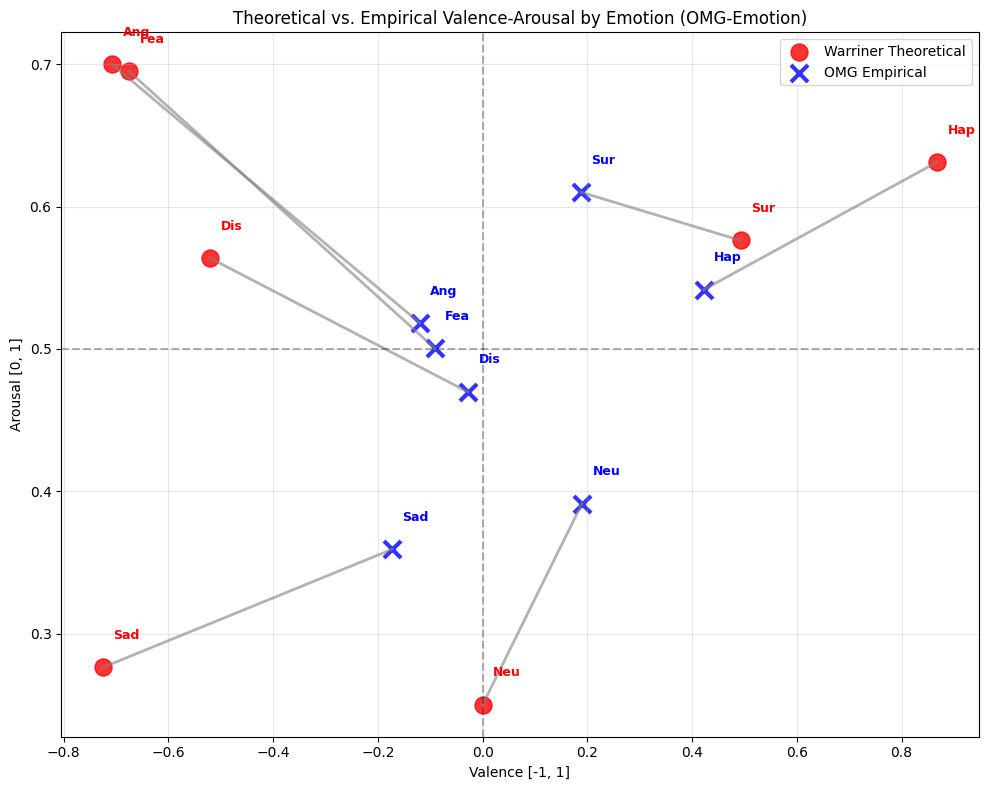


THEORETICAL vs. EMPIRICAL MAPPING:
Emotion   | Theoretical V/A   | Actual V/A        | Difference
------------------------------------------------------------
Anger    | (-0.708, +0.700) | (-0.120, +0.518) | (+0.587, -0.182)
Disgust  | (-0.520, +0.564) | (-0.028, +0.470) | (+0.492, -0.094)
Fear     | (-0.675, +0.695) | (-0.091, +0.501) | (+0.584, -0.194)
Happy    | (+0.868, +0.631) | (+0.422, +0.542) | (-0.445, -0.090)
Neutral  | (+0.000, +0.250) | (+0.190, +0.391) | (+0.190, +0.141)
Sad      | (-0.725, +0.276) | (-0.173, +0.359) | (+0.552, +0.083)
Surprise | (+0.492, +0.576) | (+0.187, +0.610) | (-0.305, +0.034)

Alignment Metrics:
  Valence MSE: 0.2228
  Arousal MSE: 0.0165
  Overall RMSE: 0.3459


In [ ]:
plt.figure(figsize=(10, 8))

plt.scatter(aggregated['theoretical_valence'], aggregated['theoretical_arousal'],
           s=150, c='red', marker='o', label='Warriner Theoretical', alpha=0.8)
plt.scatter(aggregated['actual_valence_mean'], aggregated['actual_arousal_mean'],
           s=150, c='blue', marker='x', label='OMG Empirical', alpha=0.8, linewidth=3)

# Add connection lines to show displacement
for _, row in aggregated.iterrows():
    theo_v = row['theoretical_valence']
    theo_a = row['theoretical_arousal'] 
    act_v = row['actual_valence_mean']
    act_a = row['actual_arousal_mean']
    
    plt.plot([theo_v, act_v], [theo_a, act_a], 'gray', alpha=0.6, linewidth=2)
    
    # Add emotion labels
    plt.text(theo_v+0.02, theo_a+0.02, row['Emotion'][:3], 
             color='red', fontsize=9, fontweight='bold')
    plt.text(act_v+0.02, act_a+0.02, row['Emotion'][:3], 
             color='blue', fontsize=9, fontweight='bold')

plt.xlabel('Valence [-1, 1]')
plt.ylabel('Arousal [0, 1]')
plt.title('Theoretical vs. Empirical Valence-Arousal by Emotion (OMG-Emotion)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(0.5, color='k', linestyle='--', alpha=0.3, label='Arousal midpoint')
plt.axvline(0, color='k', linestyle='--', alpha=0.3, label='Valence neutral')
plt.tight_layout()
plt.show()

# Print numerical comparison
print("\nTHEORETICAL vs. EMPIRICAL MAPPING:")
print("=" * 60)
print("Emotion   | Theoretical V/A   | Actual V/A        | Difference")
print("-" * 60)
for _, row in aggregated.iterrows():
    theo_v = row['theoretical_valence']
    theo_a = row['theoretical_arousal']
    actual_v = row['actual_valence_mean']
    actual_a = row['actual_arousal_mean']
    
    diff_v = actual_v - theo_v
    diff_a = actual_a - theo_a
    
    print(f"{row['Emotion']:8} | ({theo_v:+6.3f}, {theo_a:+6.3f}) | ({actual_v:+6.3f}, {actual_a:+6.3f}) | ({diff_v:+6.3f}, {diff_a:+6.3f})")

# Calculate alignment metrics
differences = [(row['actual_valence_mean'] - row['theoretical_valence'], 
                row['actual_arousal_mean'] - row['theoretical_arousal']) 
               for _, row in aggregated.iterrows()]

mse_v = np.mean([d[0]**2 for d in differences])
mse_a = np.mean([d[1]**2 for d in differences])

print(f"\nAlignment Metrics:")
print(f"  Valence MSE: {mse_v:.4f}")
print(f"  Arousal MSE: {mse_a:.4f}")
print(f"  Overall RMSE: {np.sqrt((mse_v + mse_a)/2):.4f}")

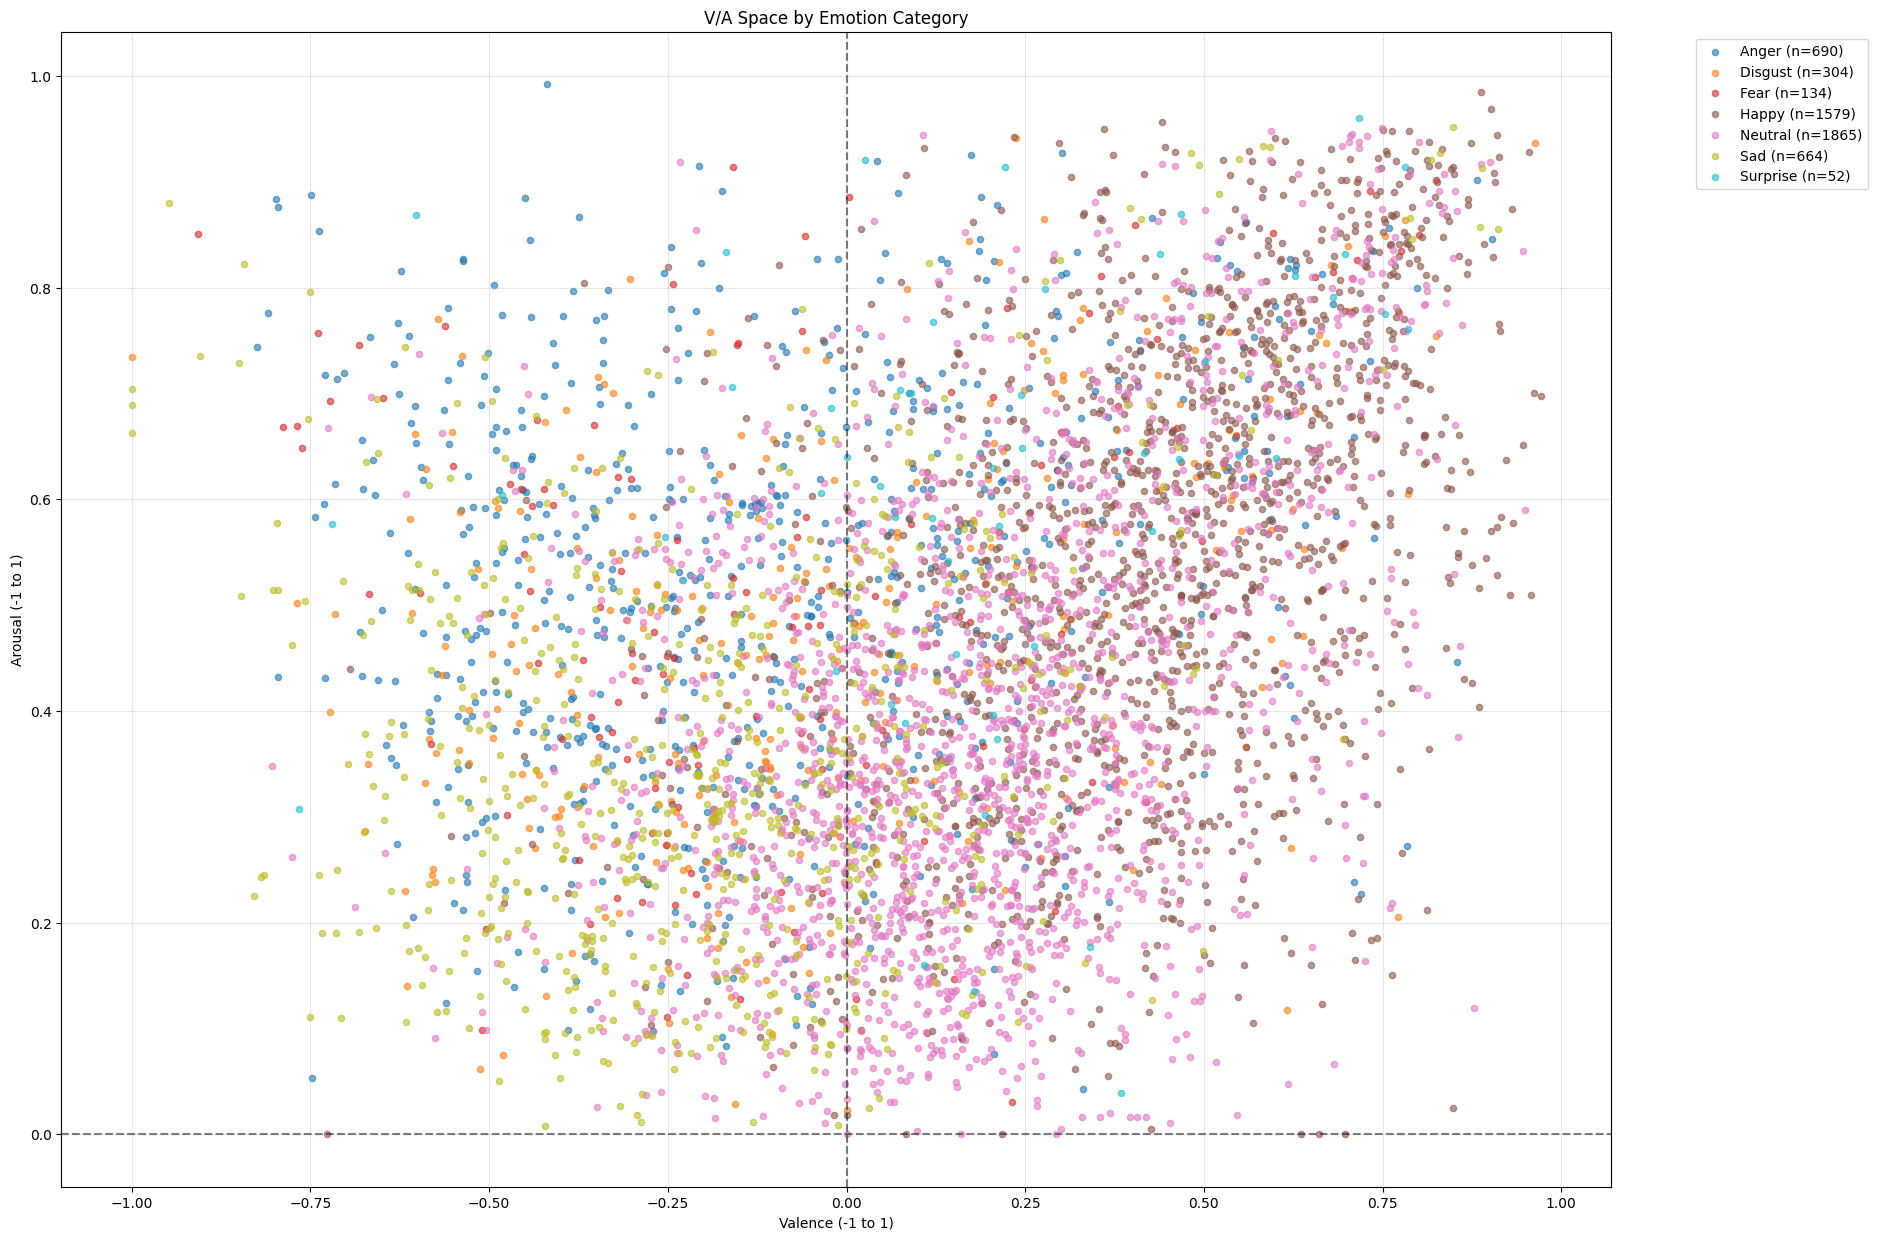

In [54]:
# Advanced Valence-Arousal Visualizations for Transfer Learning Analysis

plt.figure(figsize=(20, 15))
# Detailed V/A scatter with emotion boundaries

colors = plt.cm.tab10(np.linspace(0, 1, 7))
for i, (emotion_id, emotion_name) in enumerate(EMOTION_LABELS.items()):
    emotion_data = all_data[all_data['EmotionMaxVote'] == emotion_id]
    if len(emotion_data) > 0:
        plt.scatter(emotion_data['valence'], emotion_data['arousal'], 
                   c=[colors[i]], label=f'{emotion_name} (n={len(emotion_data)})', 
                   alpha=0.6, s=20)

plt.xlabel('Valence (-1 to 1)')
plt.ylabel('Arousal (-1 to 1)')
plt.title('V/A Space by Emotion Category')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
plt.show()

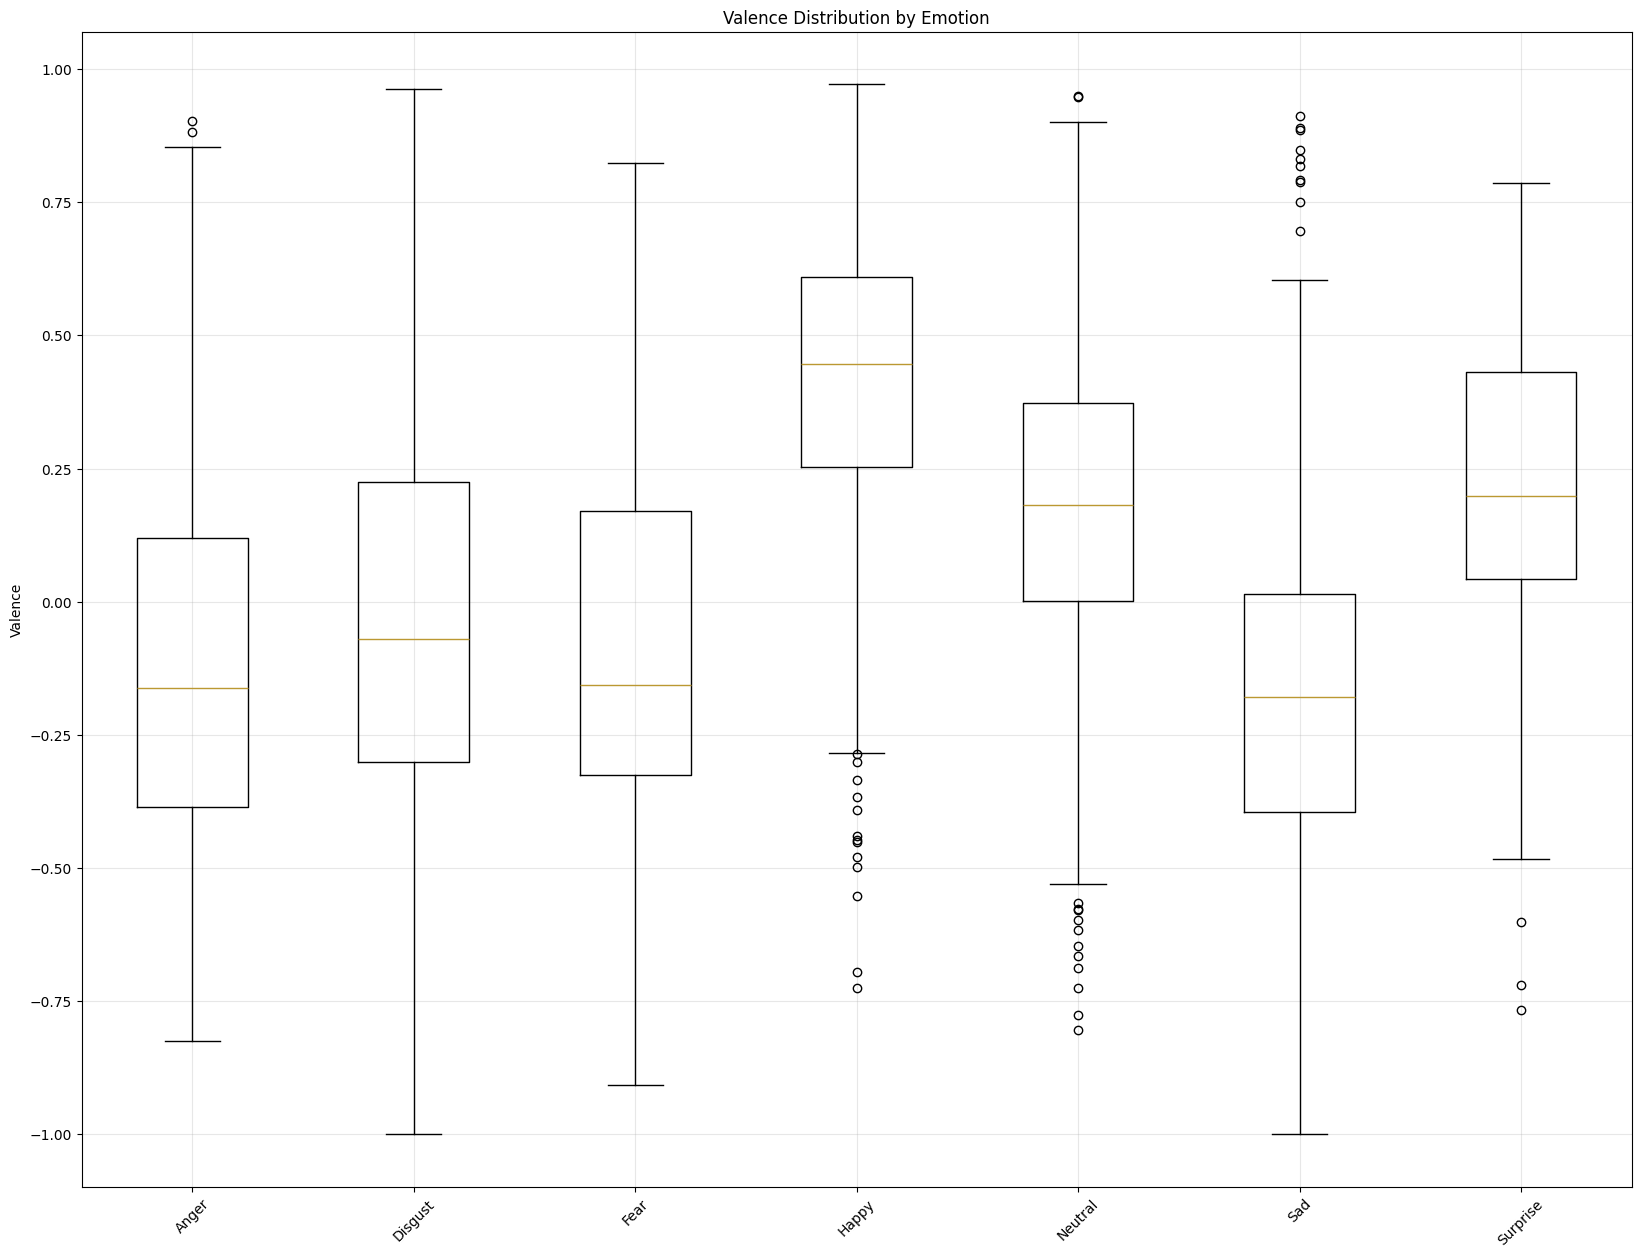

In [55]:
# Valence distribution by emotion
plt.figure(figsize=(20, 15))
valence_by_emotion = [all_data[all_data['EmotionMaxVote'] == i]['valence'].values 
                      for i in sorted(EMOTION_LABELS.keys()) 
                      if len(all_data[all_data['EmotionMaxVote'] == i]) > 0]
emotion_names_ordered = [EMOTION_LABELS[i] for i in sorted(EMOTION_LABELS.keys()) 
                        if len(all_data[all_data['EmotionMaxVote'] == i]) > 0]

plt.boxplot(valence_by_emotion, labels=emotion_names_ordered)
plt.xticks(rotation=45)
plt.ylabel('Valence')
plt.title('Valence Distribution by Emotion')
plt.grid(True, alpha=0.3)
plt.show()

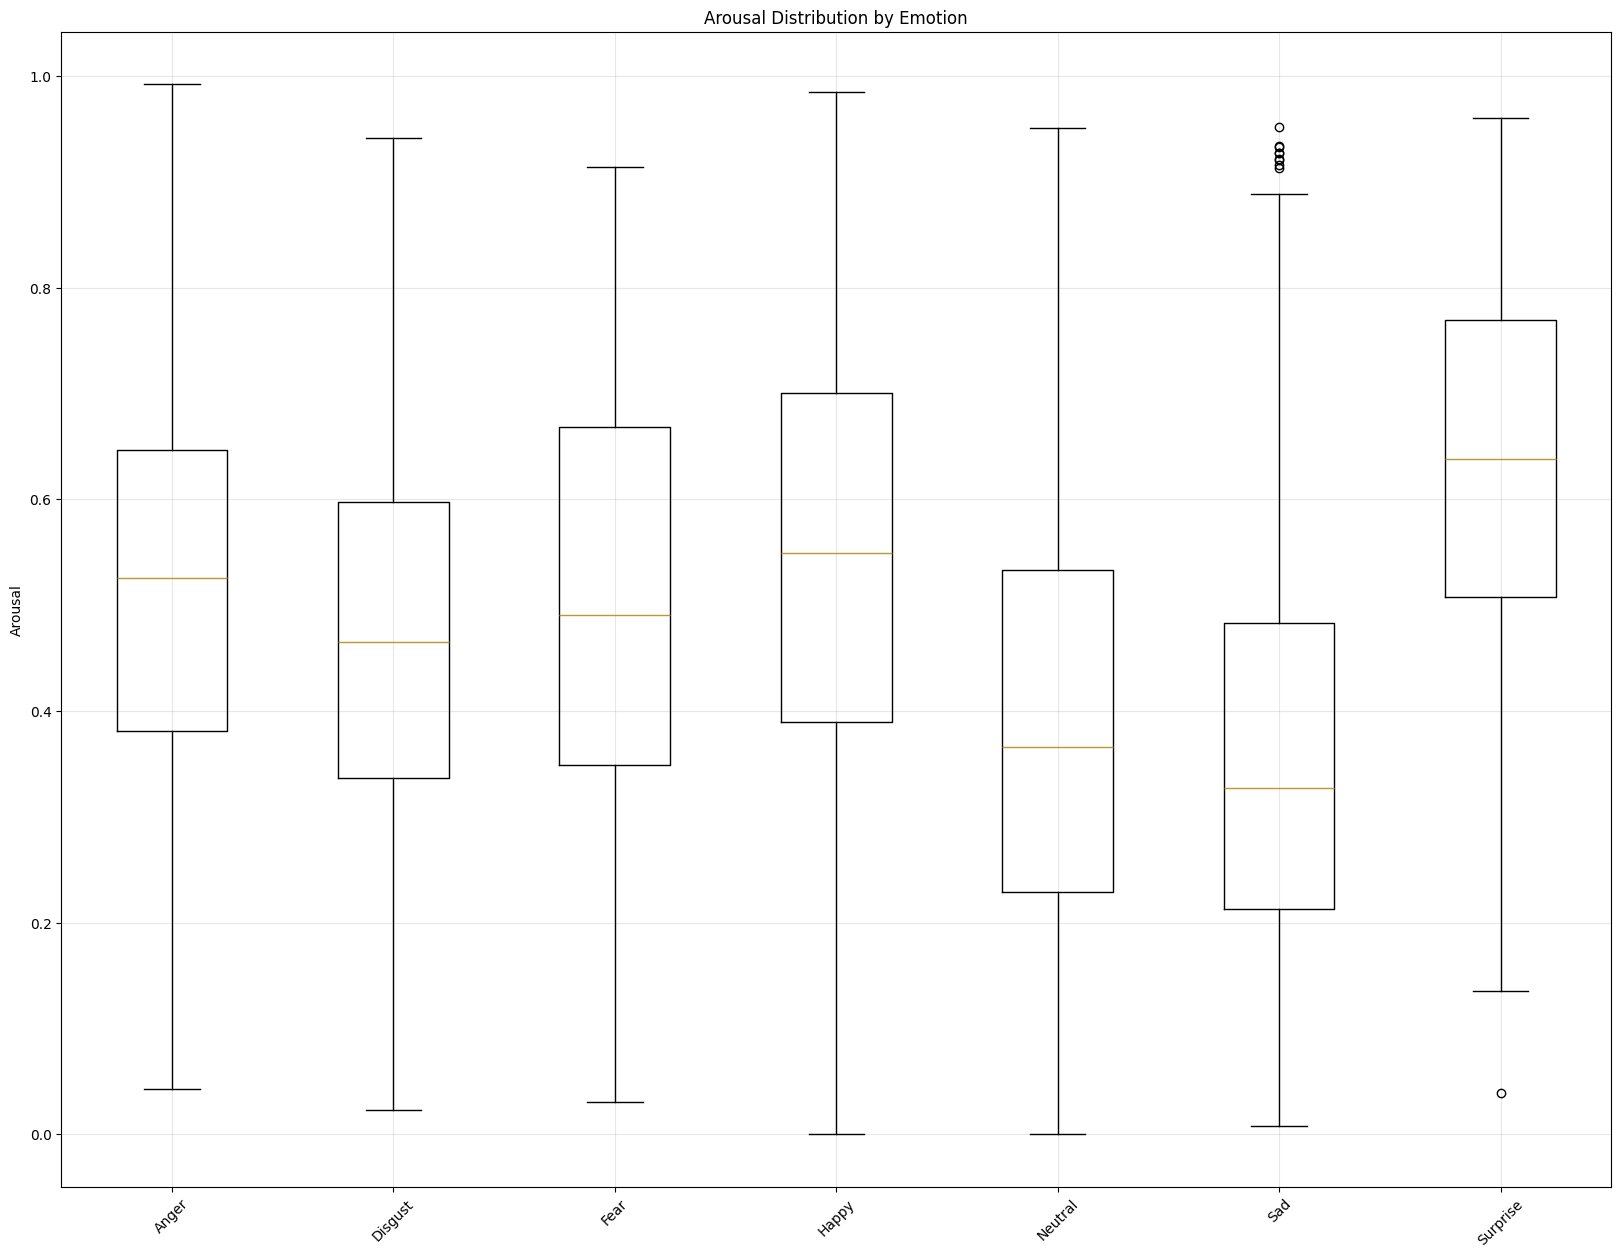

In [56]:
# Arousal distribution by emotion
plt.figure(figsize=(20, 15))
arousal_by_emotion = [all_data[all_data['EmotionMaxVote'] == i]['arousal'].values 
                      for i in sorted(emotion_labels.keys()) 
                      if len(all_data[all_data['EmotionMaxVote'] == i]) > 0]

plt.boxplot(arousal_by_emotion, labels=emotion_names_ordered)
plt.xticks(rotation=45)
plt.ylabel('Arousal')
plt.title('Arousal Distribution by Emotion')
plt.grid(True, alpha=0.3)
plt.show()